### Logistic regression
Predict house pricing of a given Bostion suburb during the '70s

### Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import models, layers, optimizers, losses, metrics
from tensorflow.keras.datasets import boston_housing

#### Datasets

Train data are features describing the suburb at the time, like crime rate, local property taxrate etc. Targets are the mediam values of owner-occupied homes, in thousands of dollars

In [2]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [3]:
train_data[0]

array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
        91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
        18.72   ])

In [4]:
train_targets[0]

15.2

### Normalizing data

Normalize data to avoid feeding the model with values having different ranges. Perform feature-wise normalization. Subtract the mean of the feature nd divide by the standard deviation.

NB: test data is also normalized with mean and standard deviation calculated on training data

In [5]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

#### Building the model

This will be a scalar regression, so the network will end with a single unit and no activation. Being the layer purely linear, the network is free to learn values in any range.

Loss: mse, mean squared error, which is the square of the difference between predictions and targets.

Other metrics: mean absolute error (mae), which is the absolute value of the difference between predictions and targets

In [6]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    
    return model

#### Validation

The dataset does not have enough datapoints to have a reliable validation set that will not suffer of high variance depending on which portion of data will be chosen. So, we will use the K-fold cross-validation method for this model.

In [7]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

In [8]:
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate([
        train_data[: i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]
        ], axis=0
    )
    partial_train_targets = np.concatenate([
        train_targets[: i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:],
        ], axis=0
    )
    
    model = build_model()
    model.fit(
        partial_train_data,
        partial_train_targets,
        epochs=num_epochs,
        batch_size=1,
        verbose=0
    )
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [9]:
all_scores

[2.2692155838012695, 2.2830090522766113, 2.693786382675171, 2.566157341003418]

In [10]:
np.mean(all_scores)

2.4530420899391174

In this case, you’re off by $2,450 on average,
which is significant considering that the prices range from $10,000 to $50,000.
Let’s try training the network a bit longer: 500 epochs. To keep a record of how
well the model does at each epoch, you’ll modify the training loop to save the perepoch
validation score log.

In [11]:
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate([
        train_data[: i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]
        ], axis=0
    )
    partial_train_targets = np.concatenate([
        train_targets[: i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:],
        ], axis=0
    )
    
    model = build_model()
    history = model.fit(
        partial_train_data,
        partial_train_targets,
        validation_data=(val_data, val_targets),
        epochs=num_epochs,
        batch_size=1,
        verbose=0
    )
    
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [12]:
average_mae_history = [
    np.mean([hist[i] for hist in all_mae_histories]) for i in range (num_epochs)
]

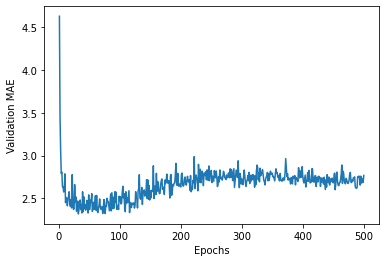

In [13]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

Despite presenting values in different scale, we can see that the MAE stops decreasing and increases again, showing a possible overfitting. In order to determine more exactly when it happens, we have to make the curve smoother:

1. omit the first 10 data points that are on a different scale;
2. replace each point with an exponential moving average of the previous points

In [14]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    
    return smoothed_points

In [15]:
smooth_mae_history = smooth_curve(average_mae_history[10:])

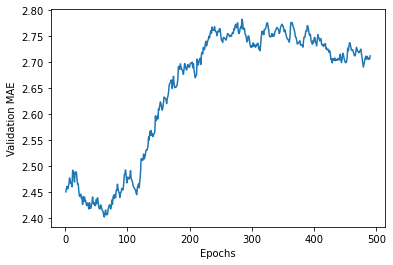

In [16]:
plt.clf()
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

According to the curve, the model starts overfitting after ~55 epochs. Let's retrain the model with the best parameters we have verified:

In [17]:
model = build_model()
model.fit(
    train_data,
    train_targets,
    epochs=55,
    batch_size=16,
    verbose=0
)
    
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 1ms/step - loss: 17.9138 - mae: 2.6530


In [18]:
test_mae_score

2.6529855728149414

The results show that we are still off by about $2650